campbell_norman clouds: dni: 684.8072460775409 dhi: 190.77800360242483 ghi: 829.141860483836
campbell_norman clearsky: dni: 1004.0145614098037 dhi: 101.51036772644967 ghi: 1037.4330108611114
Ratio clouds/clearsky: dni: 0.6820690380386091 dhi: 1.8793942714948462 ghi: 0.799224481777011
spectrl2 dhi 108.66336569340014
spectrl2 dni 1047.4141334159524
spectrl2 poa 976.4220710307679
campbell_norman clouds: dni: 643.6706272399618 dhi: 185.64415547446373 ghi: 736.309336500382
campbell_norman clearsky: dni: 976.6254941950833 dhi: 100.1905192545759 ghi: 935.7011543467869
Ratio clouds/clearsky: dni: 0.6590762078871014 dhi: 1.8529114017540635 ghi: 0.7869065171928741
spectrl2 dhi 105.34118821901565
spectrl2 dni 1028.7803588383144
spectrl2 poa 959.07248384325
campbell_norman clouds: dni: 580.8377181010006 dhi: 177.55616613230953 ghi: 614.8336457977714
campbell_norman clearsky: dni: 932.8499816607615 dhi: 98.05356293154054 ghi: 800.339719932899
Ratio clouds/clearsky: dni: 0.6226485817868912 dhi: 1.81

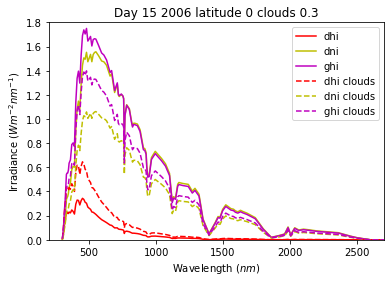

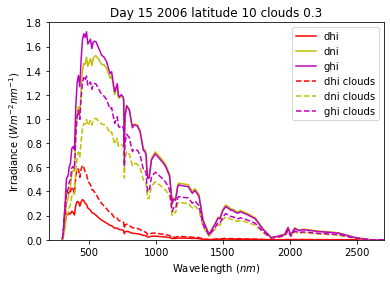

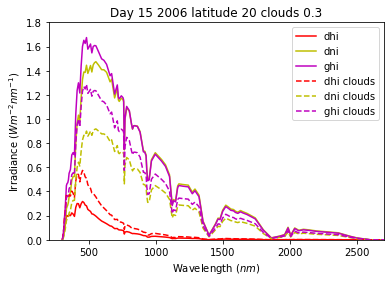

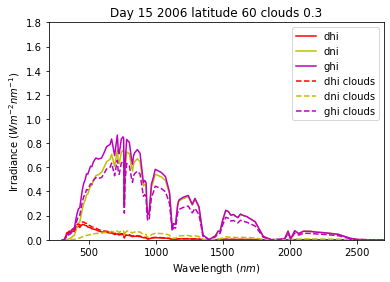

<ipython-input-73-518bb626644f>:93: RuntimeWarning: Mean of empty slice
  print("campbell_norman clouds: dni: {} dhi: {} ghi: {}".format(np.nanmean(irrads_clouds['dni']),
<ipython-input-73-518bb626644f>:94: RuntimeWarning: Mean of empty slice
  np.nanmean(irrads_clouds['dhi']),
<ipython-input-73-518bb626644f>:95: RuntimeWarning: Mean of empty slice
  np.nanmean(irrads_clouds['ghi'])))
<ipython-input-73-518bb626644f>:99: RuntimeWarning: Mean of empty slice
  print("campbell_norman clearsky: dni: {} dhi: {} ghi: {}".format(np.nanmean(irrads_clearsky['dni']),
<ipython-input-73-518bb626644f>:100: RuntimeWarning: Mean of empty slice
  np.nanmean(irrads_clearsky['dhi']),
<ipython-input-73-518bb626644f>:101: RuntimeWarning: Mean of empty slice
  np.nanmean(irrads_clearsky['ghi'])))
<ipython-input-73-518bb626644f>:103: RuntimeWarning: Mean of empty slice
  ratio_dni = np.nanmean(irrads_clouds['dni'])/np.nanmean(irrads_clearsky['dni'])
<ipython-input-73-518bb626644f>:104: RuntimeWarning: Mean o

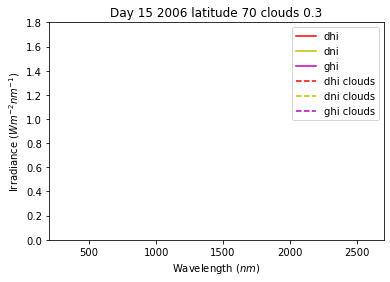

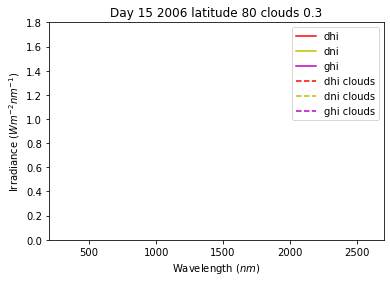

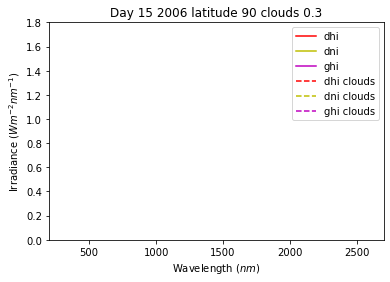

In [73]:
# Computational modules
import numpy as np
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt

def setup_pv_system(month, hour_of_day):
    offset = 0  # int(lon_180/15.)
    when = [datetime.datetime(2006, month, 15, hour_of_day, 0, 0,
                              tzinfo=datetime.timezone(datetime.timedelta(hours=offset)))]
    time = pd.DatetimeIndex(when)

    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    pv_system = {'module': module, 'inverter': inverter,
                 'surface_azimuth': 180}

    return time, pv_system

def plot_spectral_irradiance(spectra, ratio_dhi, ratio_dni, ratio_ghi, latitude,  day_of_year, year, clouds=0.0):
    fig, ax = plt.subplots()
    ax.plot(spectra['wavelength'], spectra["dhi"][:,0], c="r")
    ax.plot(spectra['wavelength'], spectra["dni"][:,0], c="y")
    ax.plot(spectra['wavelength'], spectra["poa_global"][:,0], c="m")

    ax.plot(spectra['wavelength'], spectra["dhi"][:,0]*ratio_dhi, c="r",linestyle='dashed')
    ax.plot(spectra['wavelength'], spectra["dni"][:,0]*ratio_dni, c="y", linestyle='dashed')
    ax.plot(spectra['wavelength'], spectra["poa_global"][:,0]*ratio_ghi, c="m", linestyle='dashed')


    plt.xlim(200, 2700)
    plt.ylim(0, 1.8)
    plt.title(r"Day {} {} latitude {} clouds {}".format( day_of_year, year, latitude, clouds))
    plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
    plt.xlabel(r"Wavelength ($nm$)")
    labels = ["dhi","dni","ghi","dhi clouds","dni clouds","ghi clouds"]
    ax.legend(labels)
   # plt.savefig("spectral_test_{}.png".format(latitude))
    plt.show()

month=1
hour_of_day=12

ctime, pv_system = setup_pv_system(month, hour_of_day)
altitude = 0.0
latitudes=[0,10,20,60,70,80,90]
cloud_covers=0.3

for latitude in latitudes:
    longitude = 0.0
    solpos = pvlib.solarposition.get_solarposition(ctime, latitude, longitude)

    airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'].to_numpy(),
                                                             model='kastenyoung1989')
    pressure = pvlib.atmosphere.alt2pres(altitude)
    airmass_abs = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

    apparent_zenith = solpos['apparent_zenith'].to_numpy()
    azimuth = solpos['azimuth'].to_numpy()
    surface_tilt = latitude
    surface_azimuth = pv_system['surface_azimuth']

    # cloud cover in fraction units here
    transmittance = (1.0 - cloud_covers) * 0.75
    aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, apparent_zenith, azimuth)

    water_vapor_content = 0.5
    tau500 = 0.1
    albedo = 0.06
    ozone = 0.3

    # day of year is an int64index array so access first item
    day_of_year = ctime.dayofyear[0]

    spectra = pvlib.spectrum.spectrl2(
        apparent_zenith=apparent_zenith,
        aoi=aoi,
        surface_tilt=surface_tilt,
        ground_albedo=albedo,
        surface_pressure=pressure,
        relative_airmass=airmass_relative,
        precipitable_water=water_vapor_content,
        ozone=ozone,
        aerosol_turbidity_500nm=tau500,
        dayofyear=day_of_year)

    irrads_clouds = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance)

    print("campbell_norman clouds: dni: {} dhi: {} ghi: {}".format(np.nanmean(irrads_clouds['dni']),
                                                 np.nanmean(irrads_clouds['dhi']),
                                                 np.nanmean(irrads_clouds['ghi'])))

    irrads_clearsky = pvlib.irradiance.campbell_norman(solpos['zenith'].to_numpy(), transmittance=0.75)

    print("campbell_norman clearsky: dni: {} dhi: {} ghi: {}".format(np.nanmean(irrads_clearsky['dni']),
                                                 np.nanmean(irrads_clearsky['dhi']),
                                                 np.nanmean(irrads_clearsky['ghi'])))
    # Calculate ratios
    ratio_dni = np.nanmean(irrads_clouds['dni'])/np.nanmean(irrads_clearsky['dni'])
    ratio_dhi = np.nanmean(irrads_clouds['dhi'])/np.nanmean(irrads_clearsky['dhi'])
    ratio_ghi = np.nanmean(irrads_clouds['ghi'])/np.nanmean(irrads_clearsky['ghi'])

    print("Ratio clouds/clearsky: dni: {} dhi: {} ghi: {}".format(ratio_dni,
                                                 ratio_dhi,
                                                 ratio_ghi))

    plot_spectral_irradiance(spectra,
                             ratio_dhi,
                             ratio_dni,
                             ratio_ghi,
                             latitude=latitude,
                             day_of_year=day_of_year,
                             year=ctime.year[0],
                             clouds=cloud_covers)

    integrated_irradiance_dhi = np.trapz(y=spectra['dhi'][:,0], x=spectra['wavelength'])
    integrated_irradiance_dni = np.trapz(y=spectra['dni'][:,0], x=spectra['wavelength'])
    integrated_irradiance_poa = np.trapz(y=spectra['poa_direct'][:,0], x=spectra['wavelength'])

    print("spectrl2 dhi", integrated_irradiance_dhi)
    print("spectrl2 dni", integrated_irradiance_dni)
    print("spectrl2 poa", integrated_irradiance_poa)

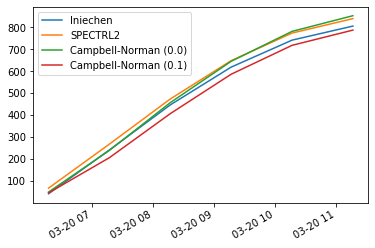

In [74]:
"""
modified version of the SPECTRL2 example here:
    https://pvlib-python.readthedocs.io/en/stable/auto_examples/plot_spectrl2_fig51A.html
"""

from pvlib import spectrum, solarposition, irradiance, atmosphere, location
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assumptions from the technical report:
lat = 37
lon = -100
tilt = 0  # choose zero so that we model horizontal irradiance
azimuth = 180
pressure = 101300  # sea level, roughly
water_vapor_content = 2.5  # cm  (increased from the example value of 0.5)
tau500 = 0.1
ozone = 0.31  # atm-cm
albedo = 0.2

times = pd.date_range('1984-03-20 06:17', freq='h', periods=6, tz='Etc/GMT+7')
solpos = solarposition.get_solarposition(times, lat, lon)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# The technical report uses the 'kasten1966' airmass model, but later
# versions of SPECTRL2 use 'kastenyoung1989'.  Here we use 'kasten1966'
# for consistency with the technical report.
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                   model='kasten1966')

spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=tilt,
    ground_albedo=albedo,
    surface_pressure=pressure,
    relative_airmass=relative_airmass,
    precipitable_water=water_vapor_content,
    ozone=ozone,
    aerosol_turbidity_500nm=tau500,
)

# integrate spectral irradiance across wavelength for each timestamp
ghi_spectrl2 = [
    np.trapz(y=spectra['poa_global'][:,i], x=spectra['wavelength'])
    for i in range(spectra['poa_global'].shape[1])
]
ghi_spectrl2 = pd.Series(ghi_spectrl2, index=times)

loc = location.Location(lat, lon)
clearsky_ineichen = loc.get_clearsky(times)

clearsky_campbell_norman_00 = irradiance.campbell_norman(solpos['zenith'], transmittance=(1.0 - 0.0) * 0.75)
clearsky_campbell_norman_01 = irradiance.campbell_norman(solpos['zenith'], transmittance=(1.0 - 0.1) * 0.75)

clearsky_ineichen['ghi'].plot(label='Iniechen')
ghi_spectrl2.plot(label='SPECTRL2')
clearsky_campbell_norman_00['ghi'].plot(label='Campbell-Norman (0.0)')
clearsky_campbell_norman_01['ghi'].plot(label='Campbell-Norman (0.1)')

plt.legend()
plt.show()